In [1]:
import pandas as pd
import torch
import torch.nn as nn
# import vaex
import numpy as np
import glob
import dask.dataframe as dd
import json
from sklearn.model_selection import train_test_split
import math
import csv
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix
import time
import _warnings
from tqdm import tqdm
import swifter
import argparse
import os
from copy import copy, deepcopy
from pathlib import Path
from concurrent import futures
from functools import partial
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

/home/tiendat/miniconda3/envs/torchtf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# OUTLINED CODE

In [13]:
odf = pd.read_csv('../data/outliners.csv')   
odf

,CONS_NO,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
0,EDFC78B07BA2908B3395C4EB2304665E,1,2.900,3.420,3.810,4.580,3.560,4.25,3.860,3.530,...,17.77,10.37,15.32,13.51,12.23,14.68,16.35,18.14,18.41,17.31
1,6BCFD78138BC72A9BA1BFB0B79382192,1,1.505,1.975,2.130,2.545,2.440,2.48,1.990,2.025,...,2.82,5.52,3.12,3.13,4.20,3.23,3.85,2.78,3.55,2.54
2,34C1954AA3703C4F8BD8EAEA7C4B7B83,1,0.110,0.530,0.450,0.510,1.320,0.71,0.120,0.520,...,4.33,2.46,1.23,3.19,1.17,1.36,0.56,1.02,1.96,1.83
3,768309B0EB11FD436CEE5ABFB84F4C0C,1,0.910,0.860,1.100,0.660,5.820,3.17,1.180,4.050,...,2.36,2.82,2.28,3.70,3.07,4.61,3.13,3.10,3.74,3.13
4,D0A186208CE83FBCCF730857C9A75B6F,1,5.965,4.550,4.520,4.290,7.065,5.28,4.725,6.050,...,3.36,3.41,4.73,3.54,4.20,2.77,3.02,4.06,4.75,4.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42363,F1472871E1AFF49D4289564B6377D76C,0,1.350,2.195,1.975,0.000,0.000,0.00,0.000,0.000,...,4.25,3.56,3.38,4.39,3.72,3.77,3.96,3.64,3.40,4.38
42364,F3C8BBCD2DC26C1E0249DEEF6A4256B7,0,2.700,4.390,3.950,0.000,0.000,0.00,0.000,0.000,...,4.81,4.87,4.48,3.67,3.31,4.58,3.33,3.19,4.57,4.00
42365,A9A0FE83467A680FBFB0DBFC910DF227,0,0.580,0.840,1.610,0.900,0.600,0.82,0.890,0.030,...,12.97,0.66,2.92,2.36,3.86,4.28,3.37,6.67,2.44,1.15
42366,D9A6ADA018FA46A55D5438370456AA45,0,16.890,13.840,13.500,14.600,14.460,12.34,15.370,17.010,...,21.13,13.75,22.61,18.83,25.52,18.11,19.31,17.48,17.20,15.28


In [14]:
# SEPARATING DEPENDENT AND INDEPENDENT VARIABLES
x = odf.iloc[:, 2:].values
y = odf.iloc[:, 1].values
print("Shape of x:", x.shape)
print("Shape of y:", y.shape)

Shape of x: (42368, 1034)
Shape of y: (42368,)


# PCA

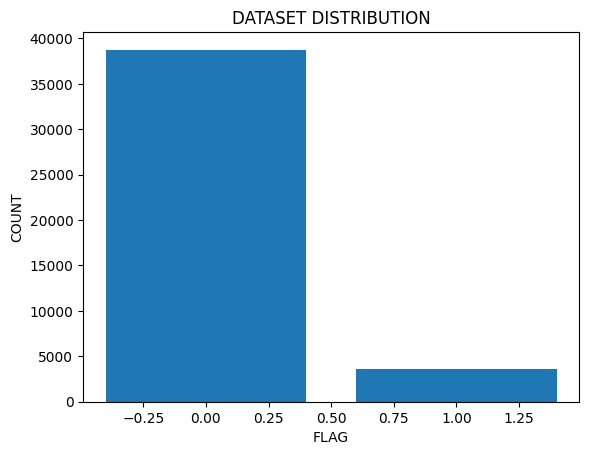

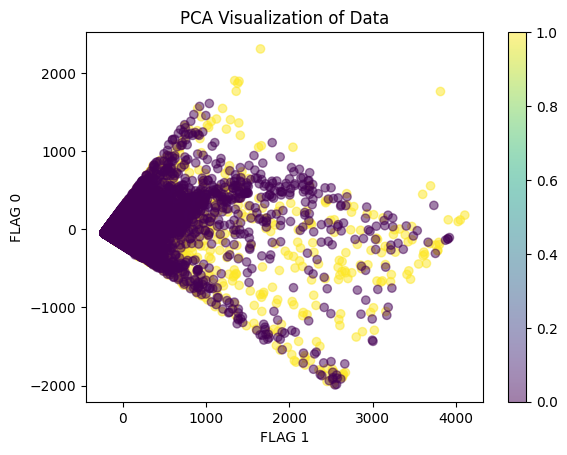

In [16]:
# Assuming you have your data in x and labels in y

# Plotting the distribution of classes in y
unique_classes, class_counts = np.unique(y, return_counts=True)
plt.bar(unique_classes, class_counts)
plt.xlabel('FLAG')
plt.ylabel('COUNT')
plt.title('DATASET DISTRIBUTION')
plt.show()

# Performing PCA to reduce the dimensionality of x for visualization
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

# Plotting the reduced x in 2D
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.xlabel('FLAG 1')
plt.ylabel('FLAG 0')
plt.title('PCA Visualization of Data')
plt.colorbar()
plt.show()

In [4]:
unique,count=np.unique(y,return_counts=True)
y_dist_val_cnt={k:v for (k,v) in zip(unique,count)}
y_dist_val_cnt

{0: 38757, 1: 3611}

# DATA PREPROCESSING

In [2]:
# Step 1: Import the file
df = pd.read_csv('../data.csv')
# df.reset_index(inplace=True)
# df.set_index('CONS_NO', inplace = True)
df

,CONS_NO,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.12,9.96,16.92,7.60,27.22,18.05,26.47,18.75,17.84,14.92
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.50,9.99,11.78,18.59,26.80,18.57,14.59,12.82,19.37,15.92
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.90,3.42,3.81,4.58,3.56,4.25,3.86,3.53,...,17.77,10.37,15.32,13.51,12.23,14.68,16.35,18.14,18.41,17.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42367,F1472871E1AFF49D4289564B6377D76C,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.25,3.56,3.38,4.39,3.72,3.77,3.96,3.64,3.40,4.38
42368,F3C8BBCD2DC26C1E0249DEEF6A4256B7,0,2.70,4.39,3.95,0.00,0.00,0.00,0.00,0.00,...,4.81,4.87,4.48,3.67,3.31,4.58,3.33,3.19,4.57,4.00
42369,A9A0FE83467A680FBFB0DBFC910DF227,0,0.58,0.84,1.61,0.90,0.60,0.82,0.89,0.03,...,NaN,0.66,2.92,2.36,3.86,4.28,3.37,6.67,2.44,1.15
42370,D9A6ADA018FA46A55D5438370456AA45,0,16.89,13.84,13.50,14.60,14.46,12.34,15.37,17.01,...,21.13,13.75,22.61,18.83,25.52,18.11,19.31,17.48,17.20,15.28


In [3]:
# (df < 0).any().any()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42372 entries, 0 to 42371
Columns: 1036 entries, CONS_NO to 2016/9/9
dtypes: float64(1034), int64(1), object(1)
memory usage: 334.9+ MB


In [14]:
df.describe()

,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
count,42372.000000,25870.000000,25912.000000,25911.000000,25912.00000,25912.000000,25912.000000,25915.000000,25924.000000,25925.000000,...,40544.000000,41482.000000,41915.000000,41151.000000,41906.000000,41873.000000,41850.000000,41967.000000,42044.000000,42027.00000
mean,0.085316,7.168735,6.954202,6.784099,7.08430,10.516470,7.219633,7.341512,7.160004,6.839875,...,8.836129,9.304656,10.758718,9.942215,11.173498,11.482926,11.656425,11.322680,11.015589,10.69165
std,0.279354,34.131237,40.017856,38.327058,31.98716,576.388348,34.703617,36.569049,36.916957,30.235396,...,52.371956,57.063621,88.039832,62.010381,94.267851,100.971180,118.369381,103.891111,100.614909,107.25814
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.660000,0.820000,0.880000,0.880000,0.900000,0.920000,0.940000,0.910000,0.910000,0.90000
50%,0.000000,3.310000,2.870000,2.900000,3.35000,3.440000,3.295000,3.470000,3.130000,3.250000,...,4.380000,4.670000,5.010000,4.820000,5.150000,5.110000,5.190000,5.110000,5.020000,4.93000
75%,0.000000,8.910000,8.170000,8.210000,8.76000,8.620000,8.740000,8.900000,8.780000,8.520000,...,9.300000,9.380000,10.740000,9.700000,11.380000,11.430000,11.600000,11.300000,10.730000,10.28000
max,1.000000,3318.000000,3966.000000,4392.000000,3414.00000,92713.900000,3167.000000,3960.000000,3654.000000,3306.000000,...,6324.000000,6990.000000,14640.000000,6672.000000,16320.000000,17100.000000,21210.000000,17940.000000,16710.000000,18570.00000


In [9]:
# Separating the consumer number and flags - columns 0 and 1
cons_flag_df = df.iloc[:, :2]
# kWhs will be sorted - columns 2 and onwards
kWhs_df = df.iloc[:, 2:]

flag = df.iloc[:, 1].values
data = df.iloc[:, 2:].values
print("Shape of data:", data.shape)
print("Shape of flag:", flag.shape)

Shape of data: (42372, 1034)
Shape of flag: (42372,)


In [6]:
kWhs_df.head()

,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,2014/1/18,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.12,9.96,16.92,7.60,27.22,18.05,26.47,18.75,17.84,14.92
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.50,9.99,11.78,18.59,26.80,18.57,14.59,12.82,19.37,15.92
4,2.9,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,...,17.77,10.37,15.32,13.51,12.23,14.68,16.35,18.14,18.41,17.31


In [15]:
# Converting the columns in the dataframe to datetime objects
kWhs_df.columns = pd.to_datetime(kWhs_df.columns).date # .date ensures we don't have to deal with timestamp
kWhs_df_sorted = kWhs_df.sort_index(axis=1, ascending=True)
kWhs_df_sorted.head()

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


In [16]:
# Adding the `CONS_NO` column to the `kWhs_df_sorted` dataframe as key for join
kWhs_df_sorted.insert(0, 'CONS_NO', df[['CONS_NO']])

# Using this column as the key on which this dataframe is joined to the CONS_NO/FLAG frame
sorted_df = pd.merge(left=cons_flag_df, right=kWhs_df_sorted, how='left', on='CONS_NO')

# Use `head` to examine the first 5 rows of the final sorted dataframe
sorted_df.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


# NaN Handling

In [17]:
description_df = sorted_df.describe()
description_df

,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
count,42372.000000,25870.000000,25873.000000,25872.000000,25874.000000,25874.000000,25878.000000,25879.000000,25907.000000,25907.000000,...,41846.000000,41824.000000,41820.000000,41665.000000,41623.000000,41397.000000,41443.000000,41637.000000,41634.000000,41569.000000
mean,0.085316,7.168735,7.057237,6.704972,7.237638,7.394550,6.939544,7.271432,6.862706,6.956579,...,9.555905,9.692272,8.503682,9.032455,9.396710,9.878270,9.934374,8.845107,8.355138,8.224294
std,0.279354,34.131237,30.086443,31.223720,49.508191,41.464202,37.583286,64.114745,34.842458,39.684055,...,77.527527,75.590148,81.278000,79.378526,80.896258,92.312243,88.382736,84.201505,78.702362,70.861576
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.790000,0.810000,0.750000,0.790000,0.810000,0.840000,0.870000,0.790000,0.770000,0.770000
50%,0.000000,3.310000,3.400000,3.110000,3.340000,3.560000,3.325000,3.120000,3.210000,3.120000,...,4.640000,4.780000,4.290000,4.420000,4.530000,4.650000,4.710000,4.450000,4.390000,4.290000
75%,0.000000,8.910000,8.570000,8.110000,8.320000,8.880000,8.290000,8.090000,8.120000,8.210000,...,9.370000,9.662500,8.400000,8.680000,9.010000,9.350000,9.510000,8.750000,8.490000,8.110000
max,1.000000,3318.000000,2500.000000,2674.000000,5670.000000,4854.000000,4170.000000,7119.810000,3546.000000,4416.000000,...,11370.000000,11100.000000,13560.000000,11940.000000,12480.000000,15180.000000,14970.000000,14100.000000,12480.000000,9990.000000


In [18]:
# Find's boolean mask of non-null values, then sums them by row - only checking kWhs
non_null_counts_by_consumer = sorted_df.iloc[:, 2:].notnull().sum(axis=1)

# Print first five values to check
non_null_counts_by_consumer.head()

0     591
1     304
2     259
3     472
4    1030
dtype: int64

Text(0.5, 1.0, 'Distribution of Non-Null kWhs Before `NaN` Replacement')

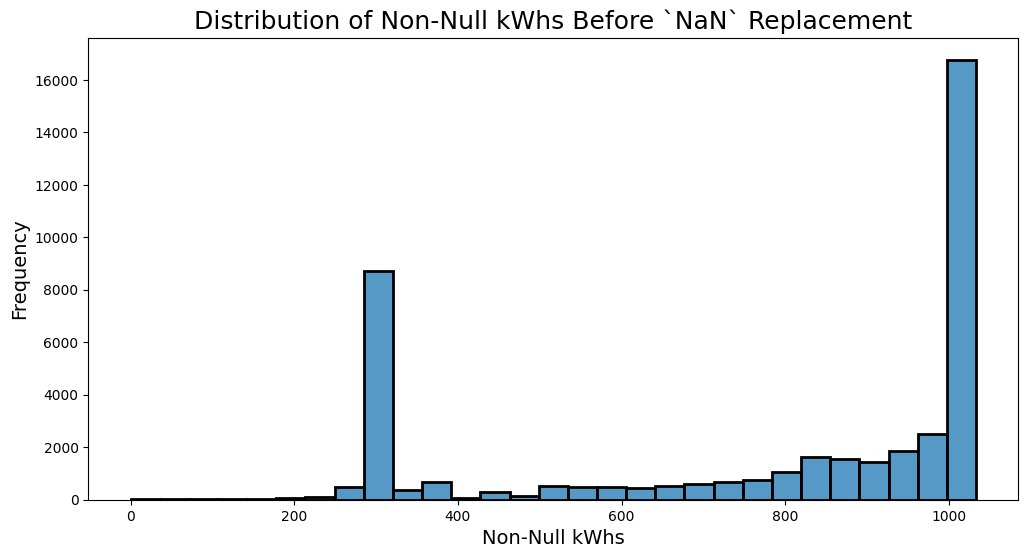

In [19]:
# Using a distribution plot to visualize non-null counts in data
plt.figure(figsize=(12, 6))
sns.histplot(non_null_counts_by_consumer, kde=False, edgecolor='k', linewidth=2)
plt.xlabel('Non-Null kWhs', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Non-Null kWhs Before `NaN` Replacement', fontsize=18)

In [20]:
# Making a deep copy so that I don't modify the original dataset
df_missing_replaced = sorted_df.copy(deep=True)

# Getting the number of consumers and kWhs 
NUM_CONSUMERS, NUM_DAYS = sorted_df.shape
print(f"Number of consumers (rows): {NUM_CONSUMERS}\nNumber of days (columns): {NUM_DAYS - 2}")
df_missing_replaced

Number of consumers (rows): 42372
Number of days (columns): 1034


,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42367,F1472871E1AFF49D4289564B6377D76C,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
42368,F3C8BBCD2DC26C1E0249DEEF6A4256B7,0,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
42369,A9A0FE83467A680FBFB0DBFC910DF227,0,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65
42370,D9A6ADA018FA46A55D5438370456AA45,0,16.89,15.15,19.28,17.19,16.80,17.48,17.86,23.99,...,15.64,16.48,13.04,10.39,12.00,11.15,12.22,13.16,13.33,10.39


In [21]:
# Attempting numpy array-based solution
kWhs = sorted_df.iloc[:, 2:].values

# Does it have the right shape
rows, cols = kWhs.shape

# Record time at beginning of loop
t_0 = time.time()

# For every consumer
for i in range(0, rows):
  # Print a dot as an update after every 400 consumers
  if (i % 400  == 0):
    print("#", end="")

  # And for every value of that consumer
  for j in range(1, cols - 1):
    # If the current value is undefined
    if (np.isnan(kWhs[i, j])):
      if (~np.isnan(kWhs[i, j - 1]) and ~np.isnan(kWhs[i, j + 1])):
        kWhs[i, j] = np.mean([kWhs[i, j - 1], kWhs[i, j + 1]])
      elif(np.isnan(kWhs[i, j - 1]) or np.isnan(kWhs[i, j + 1])):
        kWhs[i, j] = 0.0

# Record time at end of loop
t_f = time.time()
print('\n', (t_f - t_0)/60)

##########################################################################################################
 1.6970609505971272


In [22]:
# Replacing kWh values with processed numpy array values in the dataframe
df_missing_replaced.iloc[:, 2:] = kWhs

# Remaining `NaN`s are in the first and last columns - replace with 0
df_missing_replaced.fillna(0, inplace=True)

# Confirming `NaNs` have been replaced in the head
df_missing_replaced

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42367,F1472871E1AFF49D4289564B6377D76C,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
42368,F3C8BBCD2DC26C1E0249DEEF6A4256B7,0,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
42369,A9A0FE83467A680FBFB0DBFC910DF227,0,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65
42370,D9A6ADA018FA46A55D5438370456AA45,0,16.89,15.15,19.28,17.19,16.80,17.48,17.86,23.99,...,15.64,16.48,13.04,10.39,12.00,11.15,12.22,13.16,13.33,10.39


In [16]:
sorted_vals_unraveled = sorted_df.iloc[:, 2:].values.ravel()

# Remove all the NaNs from this array of kWh values
sorted_vals_filtered = sorted_vals_unraveled[~np.isnan(sorted_vals_unraveled)]

np.any(np.isnan(sorted_vals_filtered))

False

## Another way

In [48]:
# Step 2: Detect and remove rows with more than 600 NaNs
df_missing = sorted_df.copy(deep=True)
threshold = 600  # Set the threshold for NaN values
rows_to_drop = df_missing[df_missing.isnull().sum(axis=1) > threshold].index  # Get index of rows with more than 600 NaNs

# Step 3: Remove these rows from the DataFrame
df_cleaned = df_missing.drop(index=rows_to_drop)
df_cleaned

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
6,34C1954AA3703C4F8BD8EAEA7C4B7B83,1,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
7,768309B0EB11FD436CEE5ABFB84F4C0C,1,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42366,5FCE503B6B616D5023B3C46173383107,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
42367,F1472871E1AFF49D4289564B6377D76C,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
42368,F3C8BBCD2DC26C1E0249DEEF6A4256B7,0,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
42369,A9A0FE83467A680FBFB0DBFC910DF227,0,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


In [50]:
# Method 1
# Apply the linear interpolation method
# Assuming df is your DataFrame
for col in df_cleaned.columns:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
df_interpolated = df_cleaned.interpolate(method='linear', axis=1, limit_direction='both')
# Replace NaN values with 0 where interpolation couldn't be applied
df_filled = df_cleaned.fillna(0)

df_filled


,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0.0,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
3,0.0,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,0.0,1,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
6,0.0,1,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
7,0.0,1,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42366,0.0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
42367,0.0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
42368,0.0,0,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
42369,0.0,0,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


# Outliers handling

In [17]:
interpolated_data=df_missing_replaced.copy(deep=True)
interpolated_data.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


In [18]:
interpolated_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42372 entries, 0 to 42371
Columns: 1036 entries, CONS_NO to 2016-10-31
dtypes: float64(1034), int64(1), object(1)
memory usage: 335.2+ MB


In [19]:
# Extract only the kWhs
kWhs = interpolated_data.iloc[:, 2:]
kWhs.head()

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


In [20]:
# Making a copy of raw data prior to processing
kWhs_outliers_removed = kWhs.copy()

NUM_CONSUMERS, NUM_DAYS = kWhs_outliers_removed.shape
print(f"Number of consumers: {NUM_CONSUMERS}\nNumber of Days:{NUM_DAYS}")

# Compute means and standard deviations for all consumers
means_by_consumer = kWhs.mean(axis=1)
stds_by_consumer = kWhs.std(axis=1)

# Confirming that there is one mean and standard deviation per consumer
assert(len(means_by_consumer) == len(stds_by_consumer))
assert(len(means_by_consumer) == NUM_CONSUMERS)

Number of consumers: 42372
Number of Days:1034


In [21]:
# Use the mean and standard deviation to compute the threshold for each consumer
thresholds = means_by_consumer + 2 * stds_by_consumer

# Replacing outliers for each consumer 
for i in range(0, NUM_CONSUMERS, 1):
  # Update while processing by print a dot 
  if (i % 400 == 0):
    print("#", end="")

    # Compare each value (`kWh`) of each row (.iloc[i]) with its corresponding threshold
    # If exceeds threshold, replace with threshold. Otherwise, leave unchanged
    # Lambda expression + apply for faster code
    kWhs_outliers_removed.iloc[i] = kWhs_outliers_removed.iloc[i].apply(lambda kWh : thresholds[i] if kWh > thresholds[i] else kWh)

##########################################################################################################

In [22]:
outliersRemoved = kWhs_outliers_removed.copy()
outliersRemoved.insert(0, 'CONS_NO', df_missing_replaced[['CONS_NO']])
outliersRemoved.insert(1, 'FLAG', df_missing_replaced[['FLAG']])

outliersRemoved

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42367,F1472871E1AFF49D4289564B6377D76C,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
42368,F3C8BBCD2DC26C1E0249DEEF6A4256B7,0,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
42369,A9A0FE83467A680FBFB0DBFC910DF227,0,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65
42370,D9A6ADA018FA46A55D5438370456AA45,0,16.89,15.15,19.28,17.19,16.80,17.48,17.86,23.99,...,15.64,16.48,13.04,10.39,12.00,11.15,12.22,13.16,13.33,10.39


In [23]:
temp = outliersRemoved.iloc[:, 2:]
mask = temp > 100000

print(temp[mask].values[np.where(mask)])

[514991.78 233696.4  466714.4  400001.66 800003.32 400003.33 640000.
 653502.79 326753.54 554535.44 277267.72]


## SMOTE balancing
work with outliner data

In [2]:
cleaned_df = pd.read_csv('../data/new_clean_data2.csv')
cleaned_df.drop(['Unnamed: 0'], axis=1, inplace=True)
cleaned_df

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31678,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
31679,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
31680,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
31681,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,1.23,0.84,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


### VISUALIZE

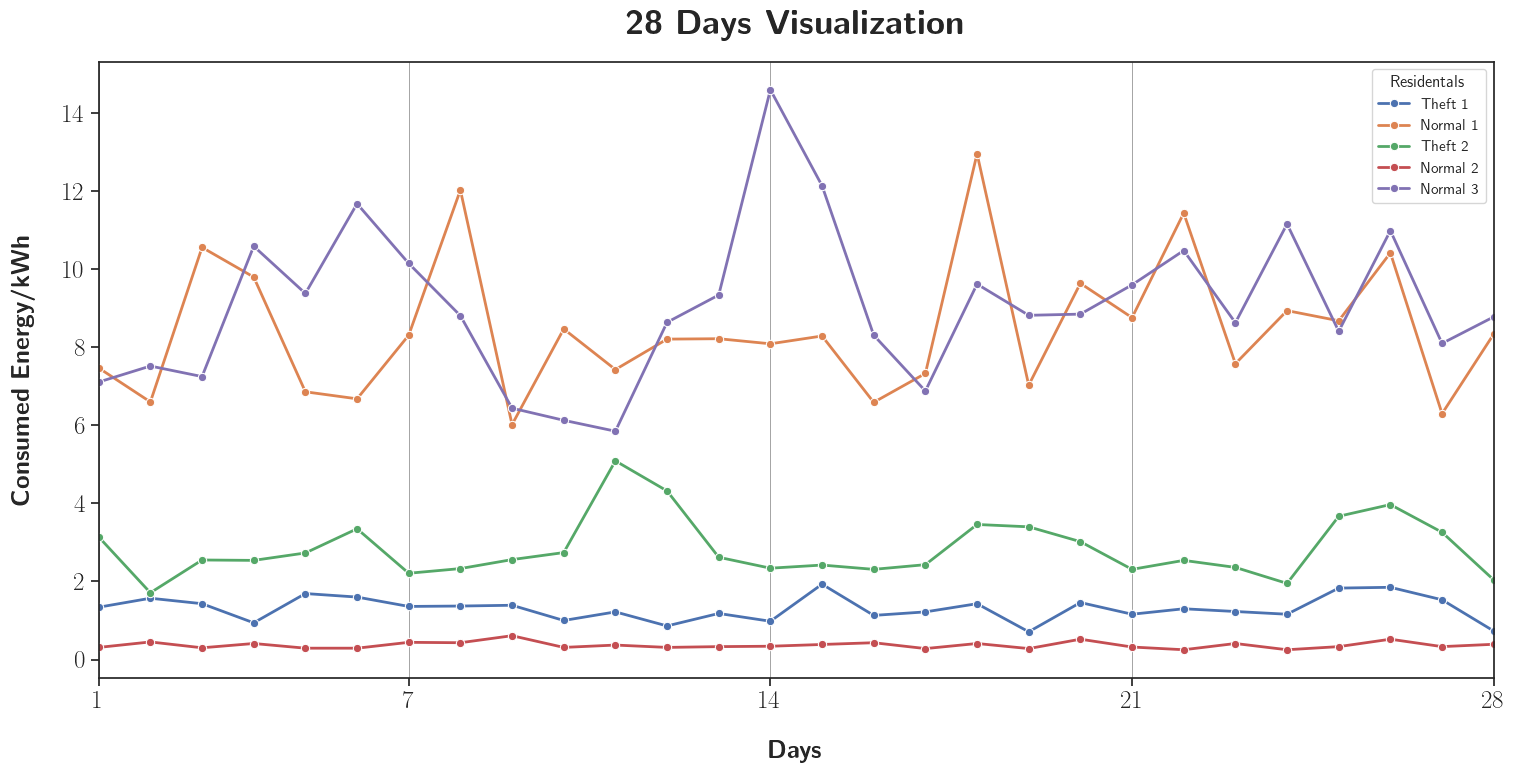

In [198]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.weight": "bold"
})

# rows = [cleaned_df.iloc[0, 0:28] for _ in range(5)]
# Assuming df is your DataFrame and you want to visualize the first row
rows = cleaned_df.iloc[[7, 2590, 10, 3617, 26723], 280:308]
# rows = [cleaned_df.iloc[2609, 0+28*i:28*i+28] for i in range(1, 10)]

# Flatten the list of rows
flat_values = np.array(rows).flatten()

# Create a new DataFrame for the selected data
data = pd.DataFrame({
    'Day': list(range(1, 29)) * len(rows),
    'Value': flat_values,
    # 'Residentals': [f'Residental {i+1}' for i in range(len(rows)) for _ in range(28)]
    'Residentals': np.array([["Theft 1" for _ in range(28)], ["Normal 1" for _ in range(28)], ["Theft 2" for _ in range(28)], ["Normal 2" for _ in range(28)], ["Normal 3" for _ in range(28)]]).flatten().tolist()
})


# Set a theme
# sns.axes_style()
sns.set_theme(style="ticks")

# Create a lineplot
plt.figure(figsize=(18, 8))

sns.lineplot(x='Day', y='Value', hue='Residentals', data=data, linewidth=2, marker='o')

# Define the markers
# markers = ['o', 'v', '^', '<', '>']

# Get the unique residentals
# residentals = data['Residentals'].unique()

# Create a lineplot for each residental
# for i, residental in enumerate(residentals):
#     df_residental = data[data['Residentals'] == residental]
#     sns.lineplot(x='Day', y='Value', data=df_residental, marker=markers[i % len(markers)], linewidth=2)

# Add title and labels
plt.title(r'\textbf{28 Days Visualization}', fontsize=25, pad=20)
plt.xlabel(r'\textbf{Days}', fontsize=18, labelpad=20)
plt.ylabel(r'\textbf{Consumed Energy/kWh}', fontsize=18, labelpad=20)

# Set xticks to only show the first and last day
plt.xticks([0, 1, 7, 14, 21, 28], fontsize=18)
plt.yticks(fontsize=18)

# Get the current axes, enabling you to manipulate its properties
ax = plt.gca()

# Display only vertical gridlines
ax.grid(True, which='both', axis='x', color='gray', linewidth=0.5)

# Set x-axis limits
plt.xlim(1, 28)

# Show the plot
plt.show()

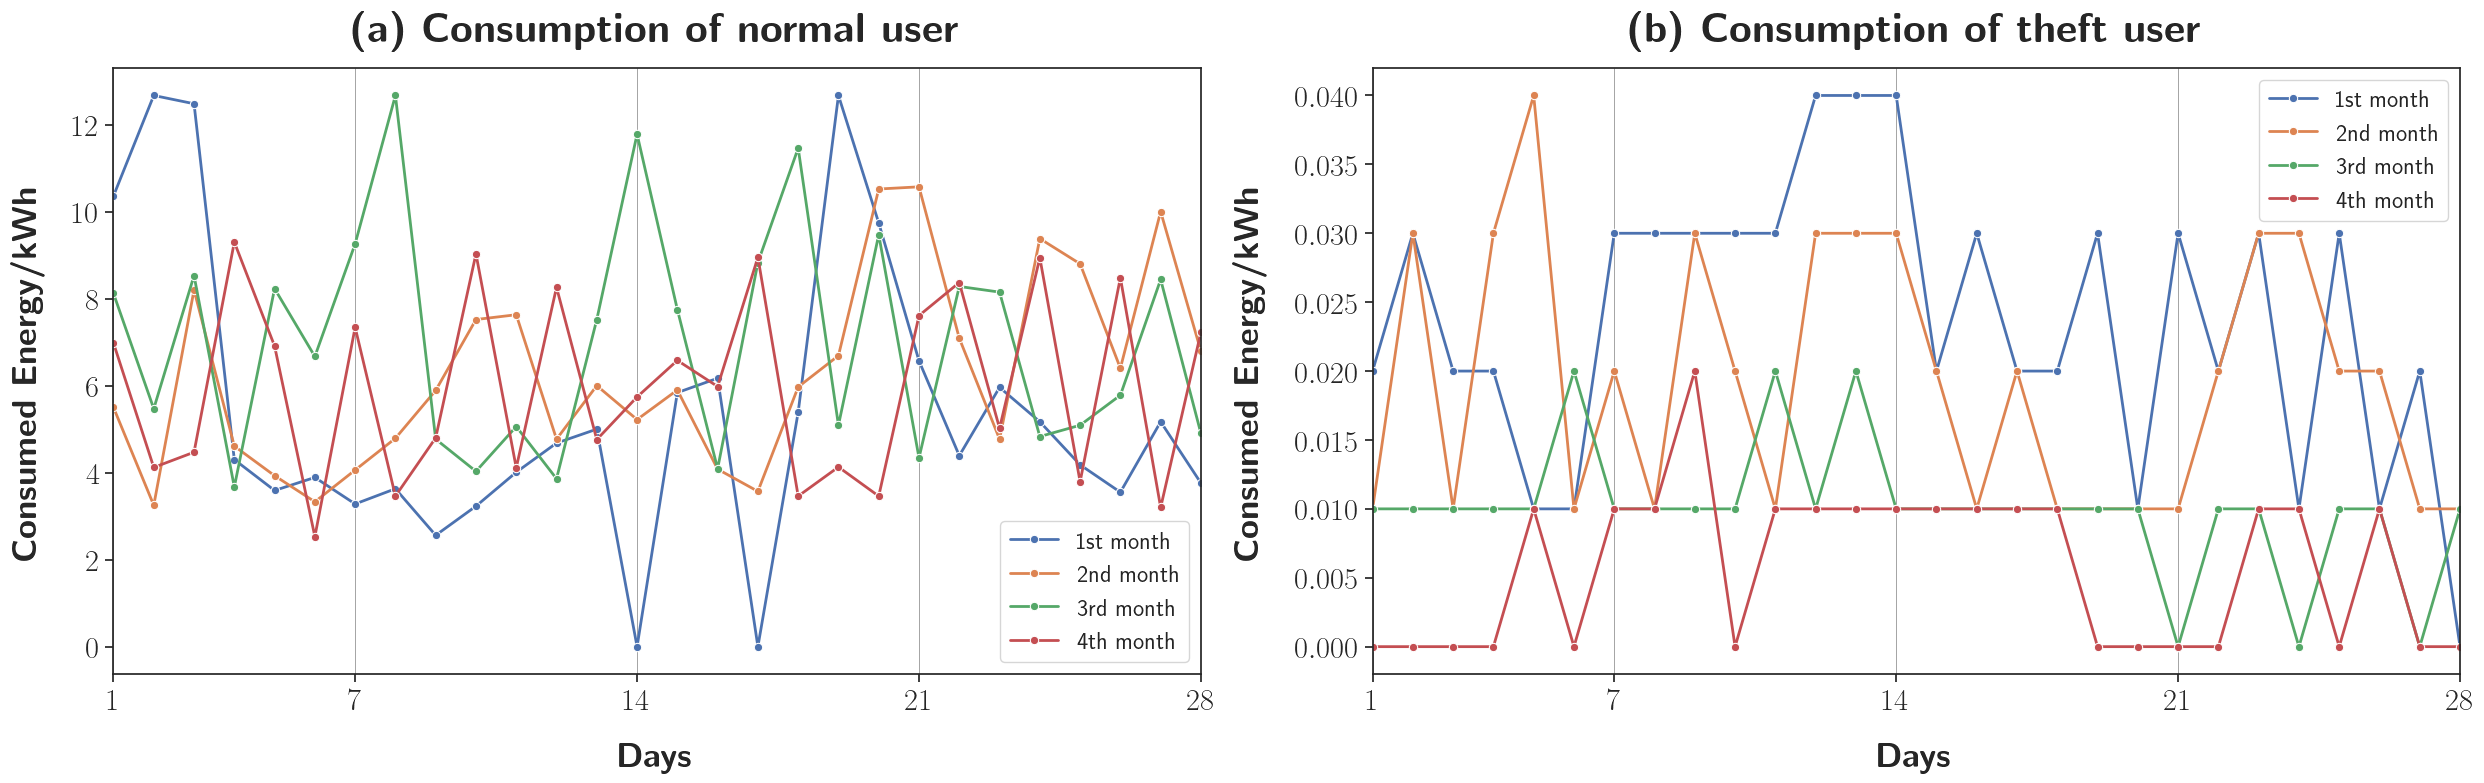

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

sns.set_theme(style="ticks")

# Assuming df is your DataFrame and you want to visualize the first row
rows = [cleaned_df.iloc[8976, 0+28*i:28*i+28] for i in range(1, 5)]

# Flatten the list of rows
flat_values = np.array(rows).flatten()

# Create a new DataFrame for the selected data
data = pd.DataFrame({
    'Day': list(range(1, 29)) * len(rows),
    'Value': flat_values,
    # 'Residentals': [f'Residental {i+1}' for i in range(len(rows)) for _ in range(28)]
    'Residentals': np.array([["1st month" for _ in range(28)], ["2nd month" for _ in range(28)], ["3rd month" for _ in range(28)], ["4th month" for _ in range(28)]]).flatten().tolist()
})

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(25, 8))

# Create the first lineplot
sns.lineplot(x='Day', y='Value', hue='Residentals', data=data, linewidth=2, marker='o', ax=axs[0])
axs[0].set_title(r'\textbf{(a) Consumption of normal user}', fontsize=30, pad=20)
axs[0].set_xlabel(r'\textbf{Days}', fontsize=25, labelpad=20)
axs[0].set_ylabel(r'\textbf{Consumed Energy/kWh}', fontsize=25, labelpad=20)
axs[0].set_xticks([0, 1, 7, 14, 21, 28])
axs[0].tick_params(axis='both', which='major', labelsize=22) 
axs[0].grid(True, which='both', axis='x', color='gray', linewidth=0.5)
axs[0].set_xlim(1, 28)
axs[0].legend(fontsize='x-large')  # Change font size of legend

# Assuming df is your DataFrame and you want to visualize the first row
rows = [cleaned_df.iloc[100, 0+28*i:28*i+28] for i in range(1, 5)]

# Flatten the list of rows
flat_values = np.array(rows).flatten()

# Create a new DataFrame for the selected data
data = pd.DataFrame({
    'Day': list(range(1, 29)) * len(rows),
    'Value': flat_values,
    # 'Residentals': [f'Residental {i+1}' for i in range(len(rows)) for _ in range(28)]
    'Residentals': np.array([["1st month" for _ in range(28)], ["2nd month" for _ in range(28)], ["3rd month" for _ in range(28)], ["4th month" for _ in range(28)]]).flatten().tolist()
})

# Create the second lineplot
# (replace 'data2' with your second DataFrame)
sns.lineplot(x='Day', y='Value', hue='Residentals', data=data, linewidth=2, marker='o', ax=axs[1])
axs[1].set_title(r'\textbf{(b) Consumption of theft user}', fontsize=30, pad=20)
axs[1].set_xlabel(r'\textbf{Days}', fontsize=25, labelpad=20)
axs[1].set_ylabel(r'\textbf{Consumed Energy/kWh}', fontsize=25, labelpad=20)
axs[1].set_xticks([0, 1, 7, 14, 21, 28])
axs[1].tick_params(axis='both', which='major', labelsize=22) 
axs[1].grid(True, which='both', axis='x', color='gray', linewidth=0.5)
axs[1].set_xlim(1, 28)
axs[1].legend(fontsize='x-large')  # Change font size of legend

# Show the plot
plt.tight_layout()
plt.show()

In [158]:
np.array([["Theft 1" for _ in range(28)], ["Normal 1" for _ in range(28)], ["Theft 2" for _ in range(28)], ["Normal 2" for _ in range(28)], ["Normal 3" for _ in range(28)]]).flatten()

array(['Theft 1', 'Theft 1', 'Theft 1', 'Theft 1', 'Theft 1', 'Theft 1',
       'Theft 1', 'Theft 1', 'Theft 1', 'Theft 1', 'Theft 1', 'Theft 1',
       'Theft 1', 'Theft 1', 'Theft 1', 'Theft 1', 'Theft 1', 'Theft 1',
       'Theft 1', 'Theft 1', 'Theft 1', 'Theft 1', 'Theft 1', 'Theft 1',
       'Theft 1', 'Theft 1', 'Theft 1', 'Theft 1', 'Normal 1', 'Normal 1',
       'Normal 1', 'Normal 1', 'Normal 1', 'Normal 1', 'Normal 1',
       'Normal 1', 'Normal 1', 'Normal 1', 'Normal 1', 'Normal 1',
       'Normal 1', 'Normal 1', 'Normal 1', 'Normal 1', 'Normal 1',
       'Normal 1', 'Normal 1', 'Normal 1', 'Normal 1', 'Normal 1',
       'Normal 1', 'Normal 1', 'Normal 1', 'Normal 1', 'Normal 1',
       'Normal 1', 'Theft 2', 'Theft 2', 'Theft 2', 'Theft 2', 'Theft 2',
       'Theft 2', 'Theft 2', 'Theft 2', 'Theft 2', 'Theft 2', 'Theft 2',
       'Theft 2', 'Theft 2', 'Theft 2', 'Theft 2', 'Theft 2', 'Theft 2',
       'Theft 2', 'Theft 2', 'Theft 2', 'Theft 2', 'Theft 2', 'Theft 2',
     

In [204]:
recall = 0.91

FNR = 1 - recall
print(FNR)

0.08999999999999997


In [111]:
flag = pd.read_csv('../data/new_info2.csv')
flag.drop(['Unnamed: 0'], axis=1, inplace=True)
flag

,FLAG,CONS_NO
0,1,0387DD8A07E07FDA6271170F86AD9151
1,1,B32AC8CC6D5D805AC053557AB05F5343
2,1,EDFC78B07BA2908B3395C4EB2304665E
3,1,34C1954AA3703C4F8BD8EAEA7C4B7B83
4,1,768309B0EB11FD436CEE5ABFB84F4C0C
...,...,...
31678,0,5FCE503B6B616D5023B3C46173383107
31679,0,F1472871E1AFF49D4289564B6377D76C
31680,0,F3C8BBCD2DC26C1E0249DEEF6A4256B7
31681,0,A9A0FE83467A680FBFB0DBFC910DF227


In [5]:
df_combined = pd.concat([flag, cleaned_df], axis=1)
df_combined

,FLAG,CONS_NO,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,1,0387DD8A07E07FDA6271170F86AD9151,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,1,B32AC8CC6D5D805AC053557AB05F5343,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,1,EDFC78B07BA2908B3395C4EB2304665E,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,1,34C1954AA3703C4F8BD8EAEA7C4B7B83,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,1,768309B0EB11FD436CEE5ABFB84F4C0C,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31678,0,5FCE503B6B616D5023B3C46173383107,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
31679,0,F1472871E1AFF49D4289564B6377D76C,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
31680,0,F3C8BBCD2DC26C1E0249DEEF6A4256B7,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
31681,0,A9A0FE83467A680FBFB0DBFC910DF227,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


In [5]:
odf

,CONS_NO,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
0,EDFC78B07BA2908B3395C4EB2304665E,1,2.900,3.420,3.810,4.580,3.560,4.25,3.860,3.530,...,17.77,10.37,15.32,13.51,12.23,14.68,16.35,18.14,18.41,17.31
1,6BCFD78138BC72A9BA1BFB0B79382192,1,1.505,1.975,2.130,2.545,2.440,2.48,1.990,2.025,...,2.82,5.52,3.12,3.13,4.20,3.23,3.85,2.78,3.55,2.54
2,34C1954AA3703C4F8BD8EAEA7C4B7B83,1,0.110,0.530,0.450,0.510,1.320,0.71,0.120,0.520,...,4.33,2.46,1.23,3.19,1.17,1.36,0.56,1.02,1.96,1.83
3,768309B0EB11FD436CEE5ABFB84F4C0C,1,0.910,0.860,1.100,0.660,5.820,3.17,1.180,4.050,...,2.36,2.82,2.28,3.70,3.07,4.61,3.13,3.10,3.74,3.13
4,D0A186208CE83FBCCF730857C9A75B6F,1,5.965,4.550,4.520,4.290,7.065,5.28,4.725,6.050,...,3.36,3.41,4.73,3.54,4.20,2.77,3.02,4.06,4.75,4.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42363,F1472871E1AFF49D4289564B6377D76C,0,1.350,2.195,1.975,0.000,0.000,0.00,0.000,0.000,...,4.25,3.56,3.38,4.39,3.72,3.77,3.96,3.64,3.40,4.38
42364,F3C8BBCD2DC26C1E0249DEEF6A4256B7,0,2.700,4.390,3.950,0.000,0.000,0.00,0.000,0.000,...,4.81,4.87,4.48,3.67,3.31,4.58,3.33,3.19,4.57,4.00
42365,A9A0FE83467A680FBFB0DBFC910DF227,0,0.580,0.840,1.610,0.900,0.600,0.82,0.890,0.030,...,12.97,0.66,2.92,2.36,3.86,4.28,3.37,6.67,2.44,1.15
42366,D9A6ADA018FA46A55D5438370456AA45,0,16.890,13.840,13.500,14.600,14.460,12.34,15.370,17.010,...,21.13,13.75,22.61,18.83,25.52,18.11,19.31,17.48,17.20,15.28


In [62]:
sampling_df = df_combined.copy(deep=True)

# Non sampling

In [19]:
# no balancing
x = sampling_df.iloc[:, 2:].values
y = sampling_df.iloc[:, 0].values

resample = pd.DataFrame(x)
print(resample.shape)
resample.head()

(31683, 1034)


,0,1,2,3,4,5,6,7,8,9,...,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91


## SMOTE

In [63]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import KMeansSMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.cluster import MiniBatchKMeans

def undersampling(X, y, ratio=1.0, choice=1):
    # Count of number of samples in each class
    class_counts = Counter(y)

    # Determining the class with fewer samples
    minority_class = min(class_counts, key=class_counts.get)
    majority_class = max(class_counts, key=class_counts.get)

    # Creating SMOTE and Undersampler instances with the specified ratio
    undersampler = RandomUnderSampler(sampling_strategy=ratio, random_state=42)
    
    if choice == 0:
        print("Using SMOTE")
        smote = SMOTE(sampling_strategy=ratio, random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)
    elif choice == 1:
        print("Using ADASYN")
        adasyn = ADASYN(sampling_strategy=ratio, random_state=42)
        X_resampled, y_resampled = adasyn.fit_resample(X, y)
    else: 
        print("Using KMeansSMOTE")
        kmean_sm = KMeansSMOTE(kmeans_estimator=MiniBatchKMeans(n_init=1, random_state=0), random_state=42)
        X_resampled, y_resampled = kmean_sm.fit_resample(X, y)
        
        
    # Applying undersampling to reduce the number of samples in the majority class
    X_resampled, y_resampled = undersampler.fit_resample(X_resampled, y_resampled)

    # Counting the number of samples in each class in the final resampled dataset
    final_class_counts = Counter(y_resampled)

    return X_resampled, y_resampled, final_class_counts

desired_ratio = 1.0
# SEPARATING DEPENDENT AND INDEPENDENT VARIABLES
x = sampling_df.iloc[:, 2:].values
y = sampling_df.iloc[:, 0].values
print("Shape of x:", x.shape)
print("Shape of y:", y.shape)

x_resampled, y_resampled, final_class_counts = undersampling(x, y, ratio=desired_ratio, choice=2)

# The final_class_counts will now contain equal numbers of samples for both classes
print("Final class counts:", final_class_counts)

Shape of x: (31683, 1034)
Shape of y: (31683,)
Using KMeansSMOTE
Final class counts: Counter({0: 29151, 1: 29151})


In [13]:
x

array([[ 0.  ,  0.  ,  0.  , ...,  7.54,  9.16,  6.74],
       [ 0.  ,  0.  ,  0.  , ..., 19.26, 14.46, 11.72],
       [ 2.9 ,  5.64,  6.99, ..., 10.89,  9.86,  8.72],
       ...,
       [ 2.7 ,  0.  ,  0.  , ...,  6.22,  6.05,  4.77],
       [ 0.58,  1.16,  0.92, ...,  0.66,  0.39,  0.65],
       [16.89, 15.15, 19.28, ..., 13.16, 13.33, 10.39]])

In [41]:
# no balancing

resample = pd.DataFrame(x)
print(resample.shape)
resample.head()

(31683, 1034)


,0,1,2,3,4,5,6,7,8,9,...,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91


In [64]:
print(y_resampled.shape)
resample = pd.DataFrame(x_resampled)
resample.head()

(58302,)


,0,1,2,3,4,5,6,7,8,9,...,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033
0,7.48,12.84,12.02,16.50,15.89,7.94,13.61,10.79,10.59,9.2,...,14.58,13.250000,11.52,9.50,14.02,14.21,13.64,10.32,16.320000,12.190000
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,8.53,6.770000,6.27,3.68,2.28,4.86,7.02,5.55,3.770000,6.920000
3,0.00,9.15,0.00,10.41,0.00,0.00,0.00,11.43,0.00,0.0,...,10.22,22.362649,15.82,13.31,12.98,15.32,12.39,16.34,22.362649,22.362649
4,0.00,0.00,0.00,11.43,0.00,0.00,0.00,11.60,0.00,0.0,...,4.81,5.210000,4.10,4.53,5.77,4.86,6.45,7.53,6.320000,5.500000


## Continue split data

In [65]:
#df_pr['data'] = df_pr[df_pr.columns].astype(float).values.tolist()
resample['data'] = resample[resample.columns].values.tolist()
df_apr = resample['data']
df_apr

0        [7.48, 12.84, 12.02, 16.5, 15.89, 7.94, 13.61,...
1        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3        [0.0, 9.15, 0.0, 10.41, 0.0, 0.0, 0.0, 11.43, ...
4        [0.0, 0.0, 0.0, 11.43, 0.0, 0.0, 0.0, 11.6, 0....
                               ...                        
58297    [25.324620296091673, 23.613497303112506, 20.53...
58298    [200.1922938667828, 211.95957116507265, 186.26...
58299    [2.38, 3.24, 3.97, 3.66, 2.58, 3.58, 3.78, 3.6...
58300    [2376.853456397411, 616.063595530886, 883.0768...
58301    [73.41703318520813, 81.22196210810982, 72.7717...
Name: data, Length: 58302, dtype: object

In [66]:
import torch.nn.functional as F

window_size = 28 # 4weeks
output_shape = (1036 // window_size, window_size)
print(output_shape)
strided_size = output_shape[0]
print(strided_size)

# padded_arr = np.pad(arr, (0, 1089 - len(arr)), 'constant')
# matrix1 = padded_arr.reshape(33, 33)

# print(np.arange(20))
# np.lib.stride_tricks.as_strided(np.arange(30), (6,5), (8*5, 8))

def stride(x):
    as_strided = np.lib.stride_tricks.as_strided
    # x = pd.Series(x) # no padding
    # print(len(x)) 1034 
    x = np.pad(pd.Series(x), (0, 2), 'constant') # padding 
    return as_strided(x, output_shape, (8*window_size, 8))
data = df_apr.apply(stride)
data

(37, 28)
37


0        [[7.48, 12.84, 12.02, 16.5, 15.89, 7.94, 13.61...
1        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3        [[0.0, 9.15, 0.0, 10.41, 0.0, 0.0, 0.0, 11.43,...
4        [[0.0, 0.0, 0.0, 11.43, 0.0, 0.0, 0.0, 11.6, 0...
                               ...                        
58297    [[25.324620296091673, 23.613497303112506, 20.5...
58298    [[200.1922938667828, 211.95957116507265, 186.2...
58299    [[2.38, 3.24, 3.97, 3.66, 2.58, 3.58, 3.78, 3....
58300    [[2376.853456397411, 616.063595530886, 883.076...
58301    [[73.41703318520813, 81.22196210810982, 72.771...
Name: data, Length: 58302, dtype: object

In [23]:
# NO BALANCING

df_dpr = data.to_frame()
df_dpr['label'] = y
df_dpr.shape

(31683, 2)

In [67]:
df_dpr = data.to_frame()
df_dpr['label'] = y_resampled
df_dpr.shape

(58302, 2)

In [68]:
data_dir = '../data'
save_file = f'{data_dir}/ksm_transformer.npz'
print('Saving to: ', save_file)
data = df_dpr['data']
label = df_dpr['label']
np.savez_compressed(save_file, data=data, label=label)

Saving to:  ../data/ksm_transformer.npz


In [69]:
np.random.seed(0)

class Writer:
    def __init__(self, outdir, type_name, start_idx=0,):
        self.outdir = Path(outdir)/ type_name
        self.outdir.mkdir(parents=True, exist_ok=True)
        self.idx = start_idx
    def write(self, X, y):
        save_file = self.outdir / f'{self.idx}.npz'
        np.savez_compressed(save_file, X=X, y=y)
        self.idx += 1
    def start(self):
        print('Start writing to: ', self.outdir)

def write_to_file(writer, X, y):
    writer.start()
    try:
        for xi, yi in tqdm(zip(X, y)):
            writer.write(xi, yi)
    except: return False
    return True

def train_test_split(N, test_fraction):
    """
    Input: 
    N: the size of the dataset
    test_fraction: the portion for test set
    Output:
    Return the index for train, val, and test set
    """
    test_size = int(N * test_fraction)
    indices = np.random.permutation(N) 
    test_idx = indices[:test_size]
    train_idx = indices[test_size:]
    return [train_idx, test_idx]

def create_folder_from_npz_file(out_dir, dir_type, fn):
    file_name = Path(data_dir) / fn
    print('Loading from: ', file_name)
    df_np = np.load(file_name, allow_pickle=True)
    print(df_np.files)
    data, label = df_np['data'], df_np['label']
    print(len(data), len(label))
    np.set_printoptions(threshold=np.inf)
    print(data[0])
    
    indices_lists = train_test_split(len(data), test_fraction=0.2) 
    prefix = ['train', 'val']
    
    for prefix, indices in zip(prefix, indices_lists):
        if prefix == dir_type:
            print(f'{prefix} size: ', len(indices))
            data_subset = data[indices] 
            label_subset = label[indices]

    out_path = out_dir  
    writer = Writer(outdir=out_path, type_name=f'{dir_type}')
    return write_to_file(writer, data_subset, label_subset)

np.set_printoptions(suppress=True)

out_dir = '../data/ksm_transformer/'
create_folder_from_npz_file(out_dir=out_dir, dir_type='train', fn='ksm_transformer.npz')
create_folder_from_npz_file(out_dir=out_dir, dir_type='val', fn='ksm_transformer.npz')

Loading from:  ../data/ksm_transformer.npz
['data', 'label']
58302 58302
[[ 7.48       12.84       12.02       16.5        15.89        7.94
  13.61       10.79       10.59        9.2        13.71       13.09
  11.39       14.12       11.19       14.63       12.94       11.82
  18.07       14.39       12.86       11.42       12.41       12.65
  14.88        8.51       11.7        16.99      ]
 [24.65       19.75       22.23       13.34       18.24       14.7
  16.48       14.25       12.06       12.84       14.16       14.75
  12.4        14.99       14.78       12.47       12.48       19.94
  18.07       12.15       13.29        8.72       15.27       14.35
  12.22        9.48       16.19       12.61      ]
 [12.53        6.16        9.5         8.18       11.54       14.13
  10.54       10.76       12.76       16.13       17.32       21.95
  15.55       14.17       13.56       12.23       14.98       13.42
  14.44       15.84       11.64       11.06       11.45       10.11
   8.93   

46642it [00:21, 2143.21it/s]


Loading from:  ../data/ksm_transformer.npz
['data', 'label']
58302 58302
[[ 7.48       12.84       12.02       16.5        15.89        7.94
  13.61       10.79       10.59        9.2        13.71       13.09
  11.39       14.12       11.19       14.63       12.94       11.82
  18.07       14.39       12.86       11.42       12.41       12.65
  14.88        8.51       11.7        16.99      ]
 [24.65       19.75       22.23       13.34       18.24       14.7
  16.48       14.25       12.06       12.84       14.16       14.75
  12.4        14.99       14.78       12.47       12.48       19.94
  18.07       12.15       13.29        8.72       15.27       14.35
  12.22        9.48       16.19       12.61      ]
 [12.53        6.16        9.5         8.18       11.54       14.13
  10.54       10.76       12.76       16.13       17.32       21.95
  15.55       14.17       13.56       12.23       14.98       13.42
  14.44       15.84       11.64       11.06       11.45       10.11
   8.93   

11660it [00:05, 1951.09it/s]


True